# Review : Density Estimation Using Real NVP

## 💫 Background Information

### ◾ NF (Normalizing Flows)
- **NF** : Encoder와 Decoder가 별개의 함수가 아닌, 함수 f와 그 역함수인 f inverse로 구성된 Generative model
- Transform a simple distribution into a complex one by applying a sequence of invertible transformation functions (층층이 쌓음)
- How to optimize **Flow-based** generative models? Minimize the negative log-likelihood
- Latent vector z로 mapping 할 때 z의 distribution을 구할 수 있다면 original pdf p(x)를 **Explicit** 하게 구할 수 있음 

### Two Conditions of transformation function $f$
- Easy to Invert
- Easy to compute Jacobian determinant

### ◾ Change of Variable Theorem
- Multivariable version : $p(x) = \pi(z)|det(dz/dx)| =  \pi(f^{-1}(x))|det(df^{-1}/dx)|$
- Meaning of Jacobian Determinant : the factor by which the function f expands or shrinks volumes near p (f가 임의의 점 p를 옮기려는 이동축만큼의 크기)
- Inverse 이용해서 원래의 pdf 나타낼 수 있음

## 💫 Paper Review

## ◾  Model
- **RealNVP (Real-valued Non-Volume Preserving)** : NF by stacking a sequence of invertible Bijective transformation functions (Affine coupling layer)
- **NICE** : NF by using coupling layers with Addictive transformation function → Volume Preserving

- What we want : Learning Highly-nonlinear models in High-dimensional continuous spaces through maximum likelihood 
- 고차원 데이터 학습을 위해 모델의 complexity를 충분히 파악해야 함 → RealNVP 등장



### 1. Change of Variable
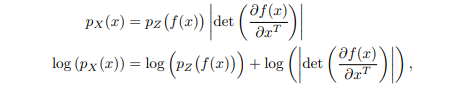
- A sample $z$ ~ $p_Z$ is drawn in Latent space <-> An image $x = f^{-1}(z) = g(z)$ generates a sample in Original space 
- What we want : $p_X(x)$ = Density on a point x = Density of its img f(x) * det(J) → Log likelihood

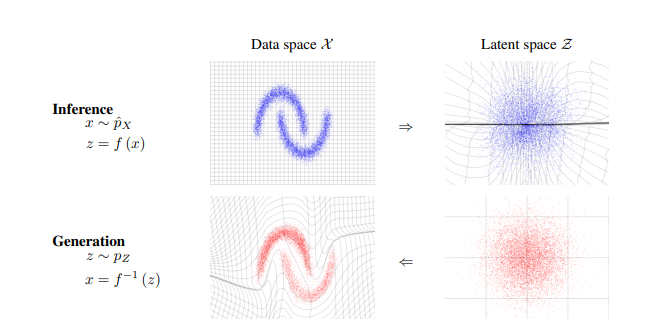

- **RealNVP** : Learning an invertible, stable, mapping bw a Data distribution $p_X$ and a Latent distribution $p_Z$
- *Inference* ($X$ → $Z$) : $f(x)$ maps samples $x$ from $p_X$ into approximate samples $z$ from $p_Z$
- *Generation* ($Z$ → $X$) : $f^{-1}(x)$ maps sample $z$ from $p_Z$ into approximate samples $x$ from $p_X$
- $f$ : Bijective (1:1 대응) transformation function
- Exact and Efficient Inference 가능!



### 2. Affine Coupling Layers
- Coupling layer : input을 둘로 나눠 각각 output으로 mapping 한 뒤 다시 합쳐 하나의 output으로 만드는 방식
- **NICE** : 내부 g function이 단순한 Addictive function인 coupling layer 사용
- **RealNVP** : $y = x$ (1:d dim) & Affine coupling layer (d+1:D dim) 사용
- 더 복잡한 data distribution을 학습하고자 x_{1:d}에 대해 Affine transformation (scale, translation) 사용

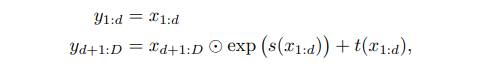



### 3. Properties
#### (1) Easy to compute Jacobian determinant
- **J (Jacobian)** : Lower Triangular matrix 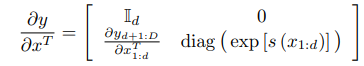
- **det(J)** : 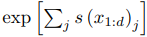
- Det of Triangular matrix : 대각 성분의 곱 <==> scale들의 합 = 구하기 쉬운 값
- det(J) 구할 때, scale factor s와 translation factor t의 jacobian 구하지 않음 → s와 t로 복잡한 DNN (Ex. ResNet) 사용 가능
- scale factor s에 exp 붙은 이유 : det(J) 구할 때 log를 상쇄시켜주기 위함


#### (2) Easy to Invert
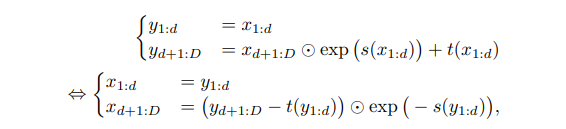



### 4. Masked Convolution
- **NICE** : Flatten 형태 feature map => input의 dimension 절반을 나눠 사용
- **RealNVP** : Image 형태 feature map => input의 split 위해 masked convolution 사용
- Two partitionings of Input $x$ with binary mask $b$ (0 or 1)
- $s( )$ and $t( )$ : rectified conv networks
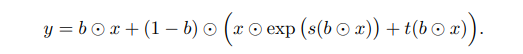


#### Two types of Binary Masking schemes for affine coupling layers
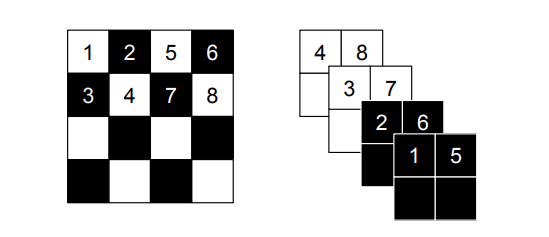

(1) Spatial Checkerboard pattern masking
- value 1 where sum of spatial coordinates is odd, and value 0 ow
- Spatial(H, W) masking
- used before squeezing 

(2) Channel-wise masking
- value 1 for the first half of channel dim and value 0 for the second half
- Channel(C) masking
- used after squeezing



### 5. Combining Coupling layers
- Problem of Coupling layers : 절반의 x가 transform 없이 남아 있음 ( $y = x$ (1:d dim) )
- Solution : Alternating pattern으로 coupling layers를 구성  

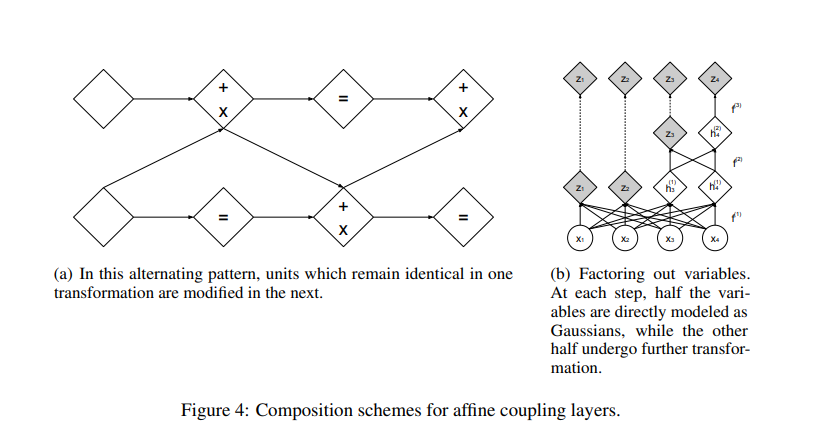



### 6. Multi-scale Architecture
#### (1) Squeezing operation
- s x s x c → s/2 x s/2 x 4c  .....  Ex) 4 x 4 x 1 tensor → 2 x 2 x 4 tensor
- 장점 : shape 변환 가능 (trading spatial size for number of channels), inverse operation 간단, reduce computation and memory 

#### (2) Combination of several operations into a sequence at each scale  (?)
- 3 **coupling** layers with checkerboard masks - **squeezing** - 3 **coupling** layers with channel-wise masking - 4 coupling layers with checkerboard masks  
- At each layer, spatial resolution is reduced & # of hidden layer features in s and t is doubled
- Final transformed output $z$ : value by concatenating different scales of z^{(i)}, $i$ = 1, ... L

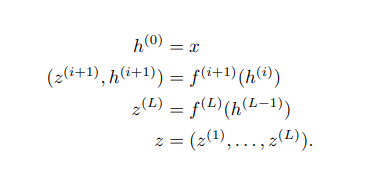



### 7. Batch Normalization
- Deep Residual Networks 사용 → s와 t에 대해 Batch Normalization & Weight Normalization 적용 
- Whole Coupling layer output에 대해 Batch Normalization 적용
- 결과 : 계산 쉬운 아주 간단한 det(J) like linear rescaling on each dim -> 더 안정적으로 deeper coupling layer 쌓을 수 있음

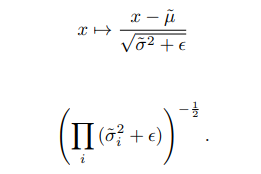



## ◾  Experiments Results

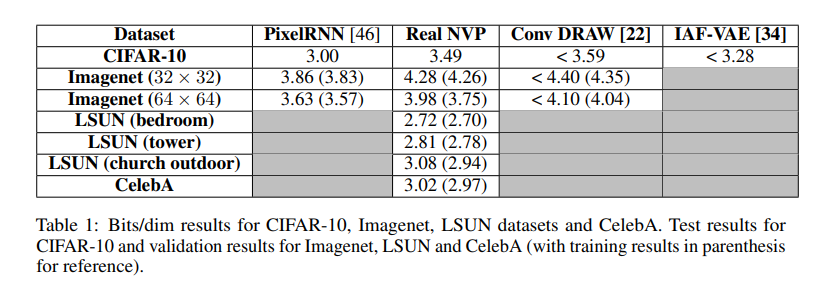
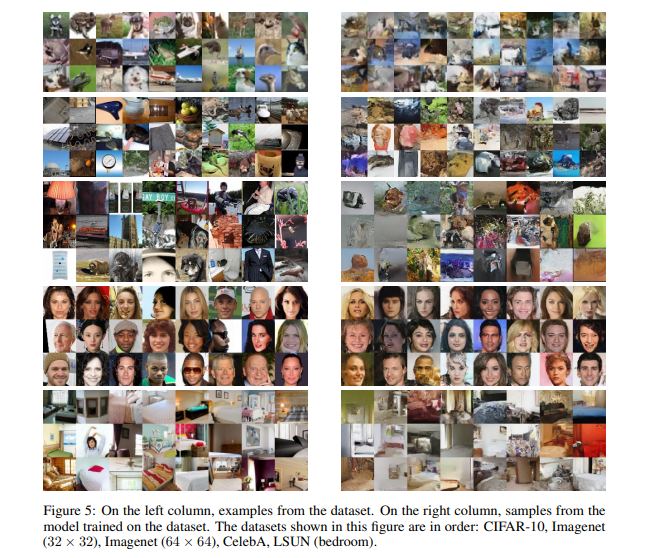
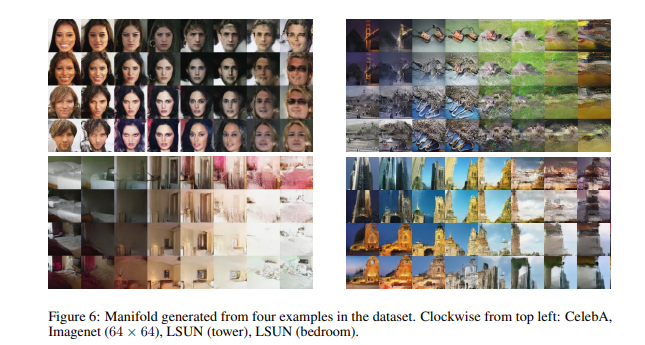


## 💫 Code Review

### 0. Setup

In [12]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.9.0


### 1. Load the data and define parameters


In [13]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

data = make_moons(3000, noise=0.05)[0].astype("float32")
data.shape

(3000, 2)

In [14]:
PARAMS = {
    'data_dim': 2,
    'embedding_dim': 256,
    'reg': 0.01,
    'coupling_MLP_num': 4,
    'K': 8,
    'latent_dim': 2,
    'nf_dim': 1,
}

### 2. Affine Coupling Layer
- relu activation을 갖는 hidden layer로 구성된 MLP
- hidden layer 개수, units 개수는 데이터 분포에 맞게 조절 가능

In [15]:
class CouplingLayer(K.models.Model):
    
    def __init__(self, params, embedding_dim, output_dim, activation, name='CouplingLayer', **kwargs):
        super(CouplingLayer, self).__init__(name=name, **kwargs)
        
        self.params = params
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.activation = activation
        self.dense = [
            layers.Dense(self.embedding_dim, activation='relu', kernel_regularizer=K.regularizers.l2(self.params['reg'])) 
            for _ in range(self.params['coupling_MLP_num'])
            ] + [
            layers.Dense(self.output_dim, activation=self.activation, kernel_regularizer=K.regularizers.l2(self.params['reg']))
            ]
        
    def call(self, x):
        for d in self.dense:
            x = d(x)
        return x

### 3. Normalizing FLow : Real NVP 
- log_likelihood : loss of model
- train_step,test_step, inverse function
- @property와 self.loss_tracker 이용해 metric을 loss들의 avg로 사용
- mask를 이용한 coupling layer 구현하는 과정에서 tf.repeat 필요 : 정확한 차원이 사전에 정의되지 않게 만듦 → model.fit() 불가 → build_graph(self) 함수 이용해 dummy 값 넣어주어 모형 내부의 차원이 모두 정의될 수 있도록 함 

In [16]:
class NormalizingFlow(K.models.Model):
    def __init__(self, params, name='NormalizingFlow', **kwargs):
        super(NormalizingFlow, self).__init__(name=name, **kwargs)
        
        self.params = params
        self.mask = np.array(
            [[0, 1], [1, 0]] * (self.params['K'] // 2), dtype="float32"
        )
        self.s = [CouplingLayer(self.params, self.params['embedding_dim'], self.params['nf_dim'], activation='tanh')
                    for _ in range(self.params['K'])]
        self.t = [CouplingLayer(self.params, self.params['embedding_dim'], self.params['nf_dim'], activation='linear')
                    for _ in range(self.params['K'])]
        
        self.loss_tracker = K.metrics.Mean(name="loss")
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
        
    def call(self, x, sum_log_abs_det_jacobians=None):
        if sum_log_abs_det_jacobians is None:
            sum_log_abs_det_jacobians = 0
        log_abs_det_jacobian = 0
        
        for i in range(self.params['K']):
            x_masked = tf.boolean_mask(x, self.mask[i], axis=1)
            x = (
                x * self.mask[i]
                + (1 - self.mask[i])
                * (x * tf.repeat(tf.math.exp(self.s[i](x_masked)), 2, axis=1) 
                   + 
                   tf.repeat(self.t[i](x_masked), 2, axis=1))
            )
            
            log_abs_det_jacobian += tf.reduce_sum(self.s[i](x_masked), axis=-1)
        sum_log_abs_det_jacobians += log_abs_det_jacobian
        return x, sum_log_abs_det_jacobians
    
    def inverse(self, x):
        for i in reversed(range(self.params['K'])):
            x_masked = tf.boolean_mask(x, self.mask[i], axis=1)
            x = (
                x * self.mask[i]
                + (1 - self.mask[i])
                * ((x - tf.repeat(self.t[i](x_masked), 2, axis=1))
                   *
                   tf.repeat(tf.math.exp(- self.s[i](x_masked)), 2, axis=1))
            )
        return x
    
    def build_graph(self):
        dummy = tf.random.normal((1, self.params['data_dim']))
        _ = self(dummy)
        return print('Graph is built!')
    
    def log_likelihood(self, x):
        x, sum_log_abs_det_jacobians = self(x)
        loss = tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=1) / 2 - sum_log_abs_det_jacobians)
        return loss
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_likelihood(data)
        grad = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}    
    
    def test_step(self, data):
        loss = self.log_likelihood(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

### 4. Model Training
- model.fit() 이전에 model.build_graphj()를 이용해 모형 내부의 차원 먼저 정확히 정의

In [18]:
model = NormalizingFlow(PARAMS)
model.build_graph()

lr_schedule = K.optimizers.schedules.ExponentialDecay(
    0.0001, 500, 0.95, staircase=False
)
model.compile(optimizer=K.optimizers.Adam(learning_rate=lr_schedule))

history = model.fit(
    data, batch_size=256, epochs=200, verbose=1, validation_split=0.2
)

Graph is built!
Epoch 1/200
10/10 [==============================] - 10s 263ms/step - loss: 0.4562 - val_loss: 0.1577
Epoch 2/200
10/10 [==============================] - 1s 85ms/step - loss: 0.0462 - val_loss: -0.0470
Epoch 3/200
10/10 [==============================] - 1s 82ms/step - loss: -0.0698 - val_loss: -0.1060
Epoch 4/200
10/10 [==============================] - 1s 85ms/step - loss: -0.1484 - val_loss: -0.1906
Epoch 5/200
10/10 [==============================] - 1s 79ms/step - loss: -0.2062 - val_loss: -0.2424
Epoch 6/200
10/10 [==============================] - 1s 80ms/step - loss: -0.2522 - val_loss: -0.2939
Epoch 7/200
10/10 [==============================] - 1s 98ms/step - loss: -0.3006 - val_loss: -0.3390
Epoch 8/200
10/10 [==============================] - 1s 105ms/step - loss: -0.3452 - val_loss: -0.3818
Epoch 9/200
10/10 [==============================] - 1s 104ms/step - loss: -0.3821 - val_loss: -0.4293
Epoch 10/200
10/10 [==============================] - 1s 98ms/ste

Epoch 159/200
10/10 [==============================] - 1s 88ms/step - loss: -1.4604 - val_loss: -1.4358
Epoch 160/200
10/10 [==============================] - 1s 102ms/step - loss: -1.4507 - val_loss: -1.4671
Epoch 161/200
10/10 [==============================] - 1s 91ms/step - loss: -1.4745 - val_loss: -1.4344
Epoch 162/200
10/10 [==============================] - 1s 98ms/step - loss: -1.4555 - val_loss: -1.4596
Epoch 163/200
10/10 [==============================] - 1s 96ms/step - loss: -1.4639 - val_loss: -1.4268
Epoch 164/200
10/10 [==============================] - 1s 99ms/step - loss: -1.4215 - val_loss: -1.3550
Epoch 165/200
10/10 [==============================] - 1s 104ms/step - loss: -1.4337 - val_loss: -1.4302
Epoch 166/200
10/10 [==============================] - 1s 106ms/step - loss: -1.4513 - val_loss: -1.4297
Epoch 167/200
10/10 [==============================] - 1s 102ms/step - loss: -1.4600 - val_loss: -1.4436
Epoch 168/200
10/10 [==============================] - 1s 93

### 5. Evaluation and Visualization

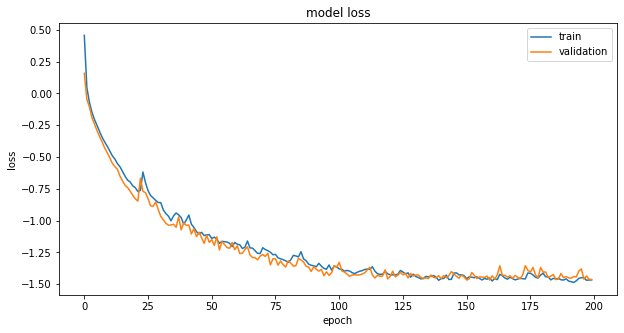

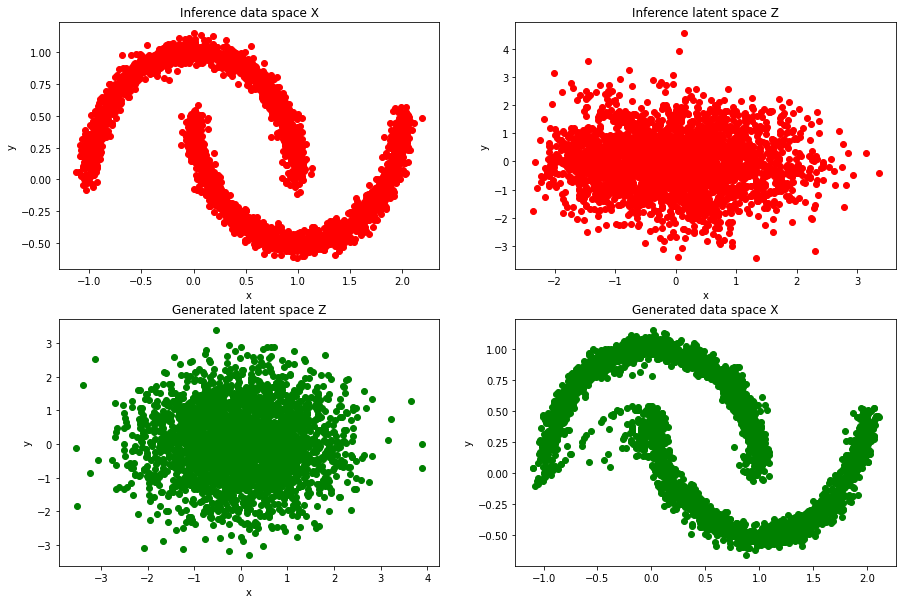

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(data)

# From latent space to data.
samples = tf.random.normal((3000, 2))
x = model.inverse(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(15, 10)

axes[0, 0].scatter(data[:, 0], data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
plt.show()

- 논문에서 제시했던 결과 시각화
- latent space Z 위의 linear interpolation이 data space X에서의 data의 분포에 따라 smooth한 interpolation을 구성함을 확인 가능

### Reference

- https://arxiv.org/pdf/1605.08803.pdf
- https://keras.io/examples/generative/real_nvp/
- https://an-seunghwan.github.io/tensorflow%202.0/reapnvp/